In [59]:
import cv2
from datetime import datetime
import numpy as np
import os, sys
import pandas as pd
import pickle
from scipy import stats
import shutil
from sklearn.cluster import KMeans
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt

sys.path.insert(0, 'src')
from utils.utils import ensure_dir, read_json, informal_log
from utils.visualizations import plot, histogram
from utils.model_utils import prepare_device
from utils.metric_utils import top_2_confusion

import model.metric as module_metric
import model.loss as module_loss
import model.model as module_model
import datasets.datasets as module_data

from train import main as train_fn
from predict import predict
from parse_config import ConfigParser


sys.path.insert(0, 'setup')
from setup_cifar10 import setup_cifar10 
# import cv2
# print(cv2.__version__)

In [3]:
cifar10_save_dir = os.path.join('saved', 'cifar10')
processed_cifar_dir = 'data/cifar10-processed'

ensure_dir(cifar10_save_dir)

### Process CIFAR-10 to get rid of bytes

In [3]:
raw_cifar_dir = 'data/cifar-10-batches-py'

if not os.path.exists(processed_cifar_dir):
    setup_cifar_10(
        raw_cifar_dir=raw_cifar_dir,
        processed_cifar_dir=processed_cifar_dir)
    print("Processing CIFAR10")
else:
    print("CIFAR-10 already processed at {}".format(processed_cifar_dir))
    

CIFAR-10 already processed at data/cifar10-processed


### Datasets for CIFAR10

In [4]:
from torch.utils.data import Dataset
from torchvision import transforms
from utils.visualizations import show_image

class CIFAR10Dataset():
    def __init__(self,
                 cifar_dir, 
                 split):
                 # normalize=False,
                 # means=[0.4914, 0.4822, 0.4465],
                 # stds=[0.2471, 0.2435, 0.2616]):
        
        assert split in ['train', 'test'], "Invalid split '{}'. Must be 'train' or 'test'".format(split)
        if split == 'train':
            files = ['data_batch_{}'.format(i) for i in range(1,6)]
        else:
            files = ['test_batch']
            
        images = []
        labels = []
        for file in files:
            path = os.path.join(cifar_dir, file)
            data = pickle.load(open(path, 'rb'))
            cur_images = data['data']
            cur_images = np.reshape(cur_images, (-1, 3, 32, 32))
            images.append(cur_images)
            
            cur_labels = np.array(data['labels'])
            labels.append(cur_labels)
        
        self.images = np.concatenate(images, axis=0)
        self.images = np.transpose(self.images, (0, 2, 3, 1)) # N x H x W x C
        
#         if normalize:
#             means = np.tile(means, (*self.images.shape[:3], 1))
#             stds = np.tile(stds, (*self.images.shape[:3], 1))
            
#             self.images = (self.images - means) / stds
#             print(means.shape)
#             print(means[0, :, 0, 0])
            # self.images = 
        self.labels = np.concatenate(labels, axis=0)
        self.n_samples = len(self.labels)
        
    def get_images(self):
        return self.images

    def get_labels(self):
        return self.labels
        
    def __len__(self):
        return self.n_samples
    
train_dataset = CIFAR10Dataset(
    cifar_dir=processed_cifar_dir,
    split='train')
        
train_images = train_dataset.get_images()
train_labels = train_dataset.get_labels()

test_dataset = CIFAR10Dataset(
    cifar_dir=processed_cifar_dir,
    split='test')
test_images = test_dataset.get_images()
test_labels = test_dataset.get_labels()

### CIFAR10 dataset for torch models

In [173]:
class CIFAR10TorchDataset(Dataset):
    def __init__(self,
                 cifar_dir,
                 split,
                 to_tensor=True,
                 normalize=True,
                 means=[0.4914, 0.4822, 0.4465],
                 stds=[0.2471, 0.2435, 0.2616]):
        
        images = []
        labels = []
        assert split in ['train', 'test'], "Invalid split '{}'. Must be 'train' or 'test'".format(split)
        if split == 'train':
            files = ['data_batch_{}'.format(i) for i in range(1,6)]
        else:
            files = ['test_batch']
            
        for file in files:
            path = os.path.join(cifar_dir, file)
            data = pickle.load(open(path, 'rb'))
            cur_images = data['data']
            cur_images = np.reshape(cur_images, (-1, 3, 32, 32))
            images.append(cur_images)
            
            cur_labels = np.array(data['labels'])
            labels.append(cur_labels)
        
        self.images = np.concatenate(images, axis=0)
        self.images = np.transpose(self.images, (0, 2, 3, 1))
        self.labels = np.concatenate(labels, axis=0)
        self.n_samples = len(self.labels)
                
        # Create transformations
        self.transforms = [transforms.ToTensor()]  # changes dims H x W x C -> C x H x W and scales to [0, 1]
        if normalize:
            self.transforms.append(transforms.Normalize(means, stds))
        self.transforms = transforms.Compose(self.transforms)
    
    def __getitem__(self, idx):
        image = self.transforms(self.images[idx])
        label = self.labels[idx]
        return image, label

    def __len__(self):
        return self.n_samples
        
train_dataset = CIFAR10(
    cifar_dir=processed_cifar_dir,
    split='train',
    to_tensor=False,
    normalize=False)

test_dataset = CIFAR10(
    cifar_dir=processed_cifar_dir,
    split='test',
    to_tensor=False,
    normalize=False)

### OpenCV's SIFT
Tutorial from [here](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)

In [6]:
MAX_FEATURES = 128
sigma = 0.5  # default is 1.6
RESIZE = (32, 32)
descriptor_size = 128
debug = True

if sigma is not None:
    sift = cv2.SIFT_create(nfeatures=MAX_FEATURES, sigma=sigma)
    print("Setting sigma to {}".format(sigma))
else: 
    sift = cv2.SIFT_create(nfeatures=MAX_FEATURES)
train_keypoints = []
train_descriptors = []

images = {
    'train': train_images,
    'test': test_images
}
sift_data = {
    'train': {
        'keypoints': [],
        'descriptors': []
    },
    'test': {
        'keypoints': [],
        'descriptors': []
    }
}
for split in ['train', 'test']:
    print("Calculating keypoints and feature descriptors for CIFAR-10 {} split".format(split))
    split_images = images[split]
    split_keypoints = sift_data[split]['keypoints']
    split_descriptors = sift_data[split]['descriptors']
    for idx, image in enumerate(tqdm(split_images, total=len(split_images))):
        if debug and idx == 5:
            break
        # Image processing
        if RESIZE is not None:
            image = cv2.resize(image, RESIZE)
        image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Calculate descriptors
        keypoints, descriptors = sift.detectAndCompute(image_bw, None)
        if debug:
            img2 = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)
            plt.imshow(img2)
            plt.show()
            print("{} keypoints".format(len(keypoints)))
        if len(keypoints) == 0:
            descriptors = np.zeros((1, descriptor_size), np.float32)
        keypoint_objs = []
        for keypoint in keypoints:
            keypoint_objs.append({
                'point': keypoint.pt,
                'size': keypoint.size,
                'angle': keypoint.angle,
                'response': keypoint.response,
                'octave': keypoint.octave,
                'class_id': keypoint.class_id
            })
        split_keypoints.append(keypoint_objs)
        split_descriptors.append(descriptors)
        
    sift_data[split]['keypoints'] = split_keypoints
    sift_data[split]['descriptors'] = split_descriptors


Setting sigma to 0.5
Calculating keypoints and feature descriptors for CIFAR-10 train split


  0%|                                                 | 0/50000 [00:00<?, ?it/s]

[[0.24313725 0.17647059 0.18431373 ... 0.50196078 0.4745098  0.47058824]
 [0.07843137 0.         0.02745098 ... 0.32156863 0.30196078 0.32156863]
 [0.09019608 0.02352941 0.09411765 ... 0.30588235 0.30588235 0.26666667]
 ...
 [0.59607843 0.48235294 0.49019608 ... 0.45882353 0.10588235 0.1254902 ]
 [0.51372549 0.40784314 0.45098039 ... 0.53333333 0.22745098 0.2       ]
 [0.54509804 0.48235294 0.50980392 ... 0.68235294 0.43921569 0.35294118]]


  0%|                                                 | 0/50000 [00:00<?, ?it/s]


error: OpenCV(4.7.0) /io/opencv/modules/features2d/src/sift.dispatch.cpp:495: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'detectAndCompute'


In [48]:
assert len(sift_data['test']['keypoints']) == len(test_images)
assert len(sift_data['test']['descriptors']) == len(test_images)
assert len(sift_data['train']['keypoints']) == len(train_images)
assert len(sift_data['train']['descriptors']) == len(train_images)
# assert 
sift_save_path = os.path.join(cifar10_save_dir, 
                              'sift_{}_{}_sigma{}'.format(RESIZE[0], RESIZE[1], sigma), 
                              'sift_keypoints_descriptors.pth')
ensure_dir(os.path.dirname(sift_save_path))
if not os.path.exists(sift_save_path):
    torch.save(sift_data, sift_save_path)
    print("Saved keypoints & descriptors from train and test to {}".format(sift_save_path))
else:
    print("Path {} already exists".format(sift_save_path))

Saved keypoints & descriptors from train and test to saved/cifar10/sift_32_32_sigma0.5/sift_keypoints_descriptors.pth


### Cluster the feature descriptors

In [64]:
sift_data_path = os.path.join(cifar10_save_dir, 
                              'sift_{}_{}_sigma{}'.format(RESIZE[0], RESIZE[1], sigma), 
                              'sift_keypoints_descriptors.pth')
sift_data = torch.load(sift_data_path)
train_descriptors = sift_data['train']['descriptors']
flat_train_descriptors = np.concatenate(train_descriptors, axis=0)
print(flat_train_descriptors.shape)

(1336295, 128)


#### Hyperparameter search for the optimal number of clusters

In [65]:
ks = [5, 10, 50, 75, 100, 150]
n_init = 10
inertias = []

for k in ks:
    print("Calculating k-means for k={}".format(k))
    kmeans = KMeans(n_clusters=k, n_init=n_init)
    kmeans = kmeans.fit(flat_train_descriptors)
    print("Inertia: {}".format(kmeans.inertia_))
    inertias.append(kmeans.inertia_)
    
plot(
    xs=ks,
    ys=inertias)

Calculating k-means for k=5
Inertia: 169553559552.0
Calculating k-means for k=10
Inertia: 157202137088.0
Calculating k-means for k=50
Inertia: 132387971072.0
Calculating k-means for k=75
Inertia: 127294603264.0
Calculating k-means for k=100
Inertia: 123837390848.0
Calculating k-means for k=150


KeyboardInterrupt: 

[5, 10, 50, 75, 100, 150] [169553559552.0, 157202137088.0, 132387971072.0, 127294603264.0, 123837390848.0]


(<Figure size 432x288 with 1 Axes>, <Axes: >)

<Figure size 432x288 with 0 Axes>

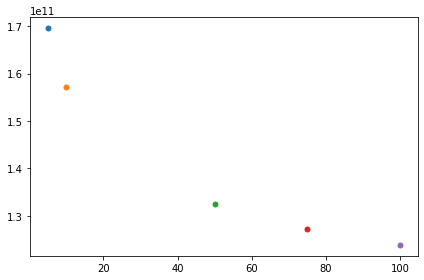

In [67]:
print(ks, inertias)
plot(
    xs=ks[:-1],
    ys=inertias)

#### Make clusters 

In [68]:
k = 50
n_init = 1
print("Calculating kmeans clusters with k={}".format(k))
kmeans = KMeans(n_clusters=k, n_init=n_init)
kmeans = kmeans.fit(flat_train_descriptors)


Calculating kmeans clusters with k=50


In [70]:
kmeans_save_path = os.path.join(cifar10_save_dir, 
                                'sift_{}_{}_sigma{}'.format(RESIZE[0], RESIZE[1], sigma),
                                '{}means'.format(k), 
                                'descriptor_kmeans.pth')
ensure_dir(os.path.dirname(kmeans_save_path))
if not os.path.exists(kmeans_save_path):
    torch.save(kmeans, kmeans_save_path)
    print("K-means with k={} saved to '{}".format(k, kmeans_save_path))
else:
    print("K-means model already saved to {}".format(kmeans_save_path))

K-means with k=50 saved to 'saved/cifar10/sift_32_32_sigma0.5/50means/descriptor_kmeans.pth


#### For each descriptor in training and test set, create a histogram representing the features present

In [71]:
kmeans_path = os.path.join(cifar10_save_dir, 
                                'sift_{}_{}_sigma{}'.format(RESIZE[0], RESIZE[1], sigma),
                                '{}means'.format(k), 
                                'descriptor_kmeans.pth')

kmeans = torch.load(kmeans_path)
debug = False

histogram_data = {}
# for split, descriptors in zip(['train', 'test'], [train_descriptors, test_descriptors]):
for split in ['train', 'test']:
    descriptors = sift_data[split]['descriptors']
    histogram_vectors = []

    for idx, image_descriptors in enumerate(tqdm(descriptors, total=len(descriptors))):
        if debug and idx == 5:
            break
        n_descriptors = len(image_descriptors)
        descriptor_clusters = kmeans.predict(image_descriptors)
        histogram = np.zeros(k)
        for cluster_idx in descriptor_clusters:
            histogram[cluster_idx] += 1 / n_descriptors  # add 1/n_descriptors bc histogram will be normalized

        histogram_vectors.append(histogram)
    histogram_vectors = np.stack(histogram_vectors, axis=0)
    histogram_data[split] = histogram_vectors


100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2224.38it/s]


In [72]:
print("Train shape: {} Test shape: {}".format(histogram_data['train'].shape, histogram_data['test'].shape))
histogram_vectors_save_path = os.path.join(
    os.path.dirname(kmeans_path), 'histogram_vectors.pth')
if not os.path.exists(histogram_vectors_save_path):
    torch.save(histogram_data, histogram_vectors_save_path)
    print("Saved train histogram vectors to {}".format(histogram_vectors_save_path))
else:
    print("Histogram vectors already exists at {}".format(histogram_vectors_save_path))

Train shape: (50000, 50) Test shape: (10000, 50)
Saved train histogram vectors to saved/cifar10/sift_32_32_sigma0.5/50means/histogram_vectors.pth


### Get CIFAR10 model's predictions

In [170]:
sys.path.insert(0, 'src')
from model.base_model import BaseModel
sys.path.insert(0, os.path.join('external_code', 'PyTorch_CIFAR10'))
# from cifar10_models.densenet import densenet121, densenet161, densenet169
# from cifar10_models.googlenet import googlenet
# from cifar10_models.inception import inception_v3
# from cifar10_models.mobilenetv2 import mobilenet_v2
from cifar10_models.resnet import resnet18, resnet34, resnet50

class CIFAR10PretrainedModel(BaseModel):
    '''
    Simple model wrapper for models in external_code/PyTorch_CIFAR10/cifar10_models/state_dicts

    Arg(s):
        type : str
            Name of architecture, must be key in self.all_classifiers

    '''
    def __init__(self,
                 type,
                 checkpoint_path="",
                 device=None):
        super().__init__()
        self.all_classifiers = {
            # "vgg11_bn": vgg11_bn(),
            # "vgg13_bn": vgg13_bn(),
            # "vgg16_bn": vgg16_bn(),
            # "vgg19_bn": vgg19_bn(),
            "resnet18": resnet18(),
            "resnet34": resnet34(),
            "resnet50": resnet50(),
            # "densenet121": densenet121(),
            # "densenet161": densenet161(),
            # "densenet169": densenet169(),
            # "mobilenet_v2": mobilenet_v2(),
            # "googlenet": googlenet(),
            # "inception_v3": inception_v3()
        }
        if type not in self.all_classifiers:
            raise ValueError("Architecture {} not available for pretrained CIFAR-10 models".format(type))
        self.model = self.all_classifiers[type]
        # self.softmax = torch.nn.Softmax(dim=1)

        # Restore weights if checkpoint_path is valid
        self.checkpoint_path = checkpoint_path

        if self.checkpoint_path != "":
            try:
                self.restore_model(checkpoint_path)
            except:
                checkpoint = torch.load(checkpoint_path)
                self.model.load_state_dict(checkpoint)

        # Store parameters
        self.model_parameters = list(filter(lambda p: p.requires_grad, self.parameters()))
        self.n_params = sum([np.prod(p.size()) for p in self.model_parameters])

    def forward(self, x):
        self.logits = self.model(x)
        return self.logits

    def get_features(self, x):
        features = self.model.features(x)
        return features

    def get_checkpoint_path(self):
        return self.checkpoint_path

    def get_n_params(self):
        return self.n_params

In [176]:
# Create model and load data loaders
cifar10_resnet18 = CIFAR10PretrainedModel(
    type='resnet18',
    checkpoint_path='/n/fs/ac-alignment/explain-alignment/checkpoints/cifar10_state_dicts/resnet18.pt')

cifar10_train_dataset = CIFAR10TorchDataset(
    cifar_dir=processed_cifar_dir,
    split='train')
cifar10_train_dataloader = torch.utils.data.DataLoader(
    cifar10_train_dataset,
    shuffle=False,
    batch_size=256,
    num_workers=8)

cifar10_test_dataset = CIFAR10TorchDataset(
    cifar_dir=processed_cifar_dir,
    split='test')
cifar10_test_dataloader = torch.utils.data.DataLoader(
    cifar10_test_dataset,
    shuffle=False,
    batch_size=256,
    num_workers=8)

In [184]:
device, _ = prepare_device(n_gpu_use=1)
cifar10_resnet18 = cifar10_resnet18.to(device)
metric_fns = [getattr(module_metric, 'accuracy')]


train_predict_log = predict(
    data_loader=cifar10_train_dataloader,
    model=cifar10_resnet18,
    metric_fns=metric_fns,
    device=device)

test_predict_log = predict(
    data_loader=cifar10_test_dataloader,
    model=cifar10_resnet18,
    metric_fns=metric_fns,
    device=device)
    

100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.20it/s]


In [198]:
# Save outputs
save_path = os.path.join('saved', 'cifar10', 'resnet18', 'outputs_predictions.pth')
ensure_dir(os.path.dirname(save_path_template))
save_data = {}
for split, logs in zip(['train', 'test'], [train_predict_log, test_predict_log]):
    outputs = logs['logits']
    probabilities = torch.softmax(outputs, dim=1)
    predictions = torch.argmax(outputs, dim=1)
    
    outputs = outputs.cpu().numpy()
    probabilities = probabilities.cpu().numpy()
    predictions = predictions.cpu().numpy()
    
    split_data = {
        'outputs': outputs,
        'probabilities': probabilities,
        'predictions': predictions,
        'accuracy': logs['metrics']['accuracy']
    }
    save_data[split] = split_data

if not os.path.exists(save_path):
    torch.save(save_data, save_path)
    print("Saved train/test outputs to {}".format(save_path))
else:
    print("Train/test results already saved to {}".format(save_path)) 
        

Saved train/test outputs to saved/cifar10/resnet18/outputs_predictions.pth


### Train linear layer to predict model's soft label outputs from histogram features

#### Save explainer model's probabilities and predictions on training and validation data

In [9]:
restore_dir = 'saved/cifar10/resnet18/explainer/sift_descriptor_histogram/cifar32_32/soft_labels/0529_130252'
model_restore_path = os.path.join(restore_dir, 'models/model_best.pth')
config_json = read_json(os.path.join(restore_dir, 'models/config.json'))

device, device_ids = prepare_device(config_json['n_gpu'])
metric_fns = [getattr(module_metric, met) for met in config_json['metrics']]
loss_fn = getattr(module_loss, config_json['loss'])

model_args = config_json['arch']['args']
model = module_model.LinearLayers(
    checkpoint_path=model_restore_path,
    **model_args)

model.eval()
model = model.to(device)

# Dataloaders
dataset_args = config_json['dataset']['args']
train_descriptors_dataset = module_data.KDDataset(split='train', **dataset_args)
test_descriptors_dataset = module_data.KDDataset(split='test', **dataset_args)

dataloader_args = config_json['data_loader']['args']
train_descriptors_dataloader = torch.utils.data.DataLoader(
    train_descriptors_dataset,
    shuffle=True,
    **dataloader_args)
test_descriptors_dataloader = torch.utils.data.DataLoader(
    test_descriptors_dataset,
    shuffle=False,
    **dataloader_args)



# Evaluate on validation set as a sanity check
validation_results = predict(
        data_loader=test_descriptors_dataloader,
        model=model,
        metric_fns=metric_fns,
        device=device,
        loss_fn=loss_fn,
        output_save_path=None,
        log_save_path=None)

print("Validation accuracy: {}".format(validation_results['metrics']['accuracy']))

training_results = predict(
        data_loader=train_descriptors_dataloader,
        model=model,
        metric_fns=metric_fns,
        device=device,
        loss_fn=loss_fn,
        output_save_path=None,
        log_save_path=None)

print("Training accuracy: {}".format(training_results['metrics']['accuracy']))

LinearLayers(
  (layers): Sequential(
    (0): Linear(in_features=75, out_features=10, bias=True)
  )
)
Trainable parameters: 760


100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 52.71it/s]


Validation accuracy: 0.2411


100%|████████████████████████████████████████| 196/196 [00:00<00:00, 339.67it/s]

Training accuracy: 0.24014


In [34]:
save_path = os.path.join(restore_dir, 'outputs_predictions.pth')

val_outputs = validation_results['logits']
val_probabilities = torch.softmax(val_outputs, dim=1)
val_predictions = torch.argmax(val_outputs, dim=1)
val_outputs_predictions = {
    'outputs': val_outputs.cpu().numpy(),
    'probabilities': val_probabilities.cpu().numpy(),
    'predictions': val_predictions.cpu().numpy()
}

train_outputs = training_results['logits']
train_probabilities = torch.softmax(train_outputs, dim=1)
train_predictions = torch.argmax(train_outputs, dim=1)

train_outputs_predictions = {
    'outputs': train_outputs.cpu().numpy(),
    'probabilities': train_probabilities.cpu().numpy(),
    'predictions': train_predictions.cpu().numpy()
}

outputs_predictions = {
    'train': train_outputs_predictions,
    'test': val_outputs_predictions
}
if not os.path.exists(save_path):
    torch.save(outputs_predictions, save_path)
    print("Saved outputs, probabilities and predictions for train/val to {}".format(save_path))
else:
    print("File exists at {}".format(save_path))

Saved outputs, probabilities and predictions for train/val to saved/cifar10/resnet18/explainer/sift_descriptor_histogram/cifar32_32/soft_labels/0529_130252/outputs_predictions.pth


#### Load soft labels, model labels, and explainer labels

In [63]:
soft_labels_path = 'data/cifar10h-probs.npy'
model_outputs_path = 'saved/cifar10/resnet18/outputs_predictions.pth'
explainer_outputs_path = 'saved/cifar10/resnet18/explainer/sift_descriptor_histogram/cifar32_32/soft_labels/0529_130252/outputs_predictions.pth'
save_dir = os.path.dirname(explainer_outputs_path)
# load human soft labels
human_probabilities = np.load(soft_labels_path)
human_predictions = np.argmax(human_probabilities, axis=1)
assert len(human_predictions) == len(human_probabilities)
human_outputs = {
    'probabilities': human_probabilities,
    'predictions': human_predictions
}
           
# load model outputs
model_outputs = torch.load(model_outputs_path)['test']
# load explainer outputs
explainer_outputs = torch.load(explainer_outputs_path)['test']

n_samples = len(human_probabilities)
# Print model accuracy for sanity (should be around 90%)
model_accuracy = np.sum(model_outputs['predictions'] == human_outputs['predictions']) / n_samples
print("Model accuracy: {}".format(model_accuracy))


Model accuracy: 0.9291


In [82]:
# Calculate entropy and top2confusion from human labels
entropy = stats.entropy(human_probabilities, axis=1)
t2c = top_2_confusion(human_probabilities)
congruent = np.where(model_outputs['predictions'] == explainer_outputs['predictions'], 1, 0)
# Make dataframe
df_dict = {
    'human_labels': human_outputs['predictions'],
    'model_predictions': model_outputs['predictions'],
    'explainer_predictions': explainer_outputs['predictions'],
    'human_soft_labels': list(human_outputs['probabilities']),
    'human_entropy': entropy,
    'human_t2c': t2c,
    'congruent': congruent
}

df = pd.DataFrame(df_dict)
print(df.columns, len(df))

congruent_df = df[df['model_predictions'] == df['explainer_predictions']]
assert (len(np.unique(congruent_df['congruent'].to_numpy())) == 1 and np.unique(congruent_df['congruent'].to_numpy())[0] == 1)
incongruent_df = df[df['model_predictions'] != df['explainer_predictions']]
assert (len(np.unique(incongruent_df['congruent'].to_numpy())) == 1 and np.unique(incongruent_df['congruent'].to_numpy())[0] == 0)

print("{} congruent samples, {} incongruent samples".format(len(congruent_df), len(incongruent_df)))
assert len(congruent_df) + len(incongruent_df) == len(df)

Index(['human_labels', 'model_predictions', 'explainer_predictions',
       'human_soft_labels', 'human_entropy', 'human_t2c', 'congruent'],
      dtype='object') 10000
2411 congruent samples, 7589 incongruent samples


In [79]:
# Save dataframe
df_save_path = os.path.join(save_dir, 'soft_labels_uncertainty.csv')
if not os.path.exists(df_save_path):
    df.to_csv(df_save_path)
    print("Saved CSV to {}".format(df_save_path))
else:
    print("CSV already exists at {}".format(df_save_path))

Saved CSV to saved/cifar10/resnet18/explainer/sift_descriptor_histogram/cifar32_32/soft_labels/0529_130252/soft_labels_uncertainty.csv


#### Examine measurements in congruent vs incongruent samples

In [70]:
def congruency_statistical_tests(congruent_df, incongruent_df, metrics):
    for metric in metrics:
        congruent_values = congruent_df[metric].to_numpy()
        incongruent_values = incongruent_df[metric].to_numpy()
        mean_congruent_value = congruent_values.mean()
        std_congruent_value = congruent_values.std()
        mean_incongruent_value = incongruent_values.mean()
        std_incongruent_value = incongruent_values.std()

        print("{} congruent: {:.3f} ({:.3f})".format(confusion_metric, mean_congruent_value, std_congruent_value))
        print("{} incongruent: {:.3f} ({:.3f})".format(confusion_metric, mean_incongruent_value, std_incongruent_value))

        ttest = stats.ttest_ind(
            congruent_values,
            incongruent_values,
            equal_var=False
        )
        print("T-test for {} without equal variance: {} (p={})".format(confusion_metric, ttest.statistic, ttest.pvalue))

        ttest = stats.ttest_ind(
            congruent_values,
            incongruent_values,
            equal_var=True
        )
        print("T-test for {} with equal variance: {} (p={})".format(confusion_metric, ttest.statistic, ttest.pvalue))

In [71]:
confusion_metrics = ['human_entropy', 'human_t2c']
for metric in confusion_metrics:
    print("Mean overall {}: {:.3f} ({:.3f})".format(metric, df[metric].mean(), df[metric].std()))
print("")

congruency_statistical_tests(
    congruent_df=congruent_df,
    incongruent_df=incongruent_df,
    metrics=confusion_metrics)



Mean overall human_entropy: 0.154 (0.235)
Mean overall human_t2c: 0.079 (0.153)

human_t2c congruent: 0.125 (0.195)
human_t2c incongruent: 0.164 (0.246)
T-test for human_t2c without equal variance: -7.954375227588616 (p=2.2052075119071042e-15)
T-test for human_t2c with equal variance: -7.067288787678372 (p=1.6854006218435467e-12)
human_t2c congruent: 0.062 (0.125)
human_t2c incongruent: 0.085 (0.160)
T-test for human_t2c without equal variance: -7.28881535701748 (p=3.6054705570626156e-13)
T-test for human_t2c with equal variance: -6.441213327685048 (p=1.2397417135193397e-10)


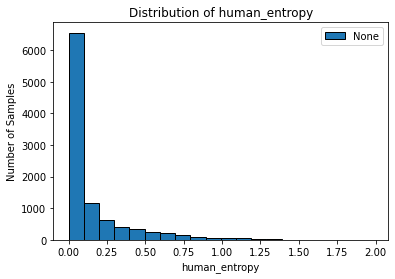

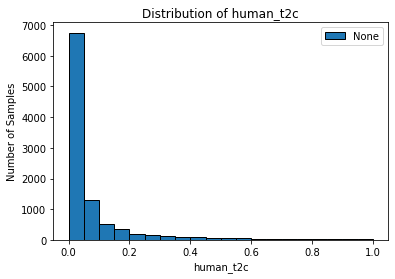

<Figure size 432x288 with 0 Axes>

In [66]:
# Plot distribution of confusion metrics
for confusion_metric in confusion_metrics:
    histogram(
        data=[df[confusion_metric].to_numpy()],
        title="Distribution of {}".format(confusion_metric),
        xlabel=confusion_metric,
        ylabel="Number of Samples",
        n_bins=20,
        show=True
    )

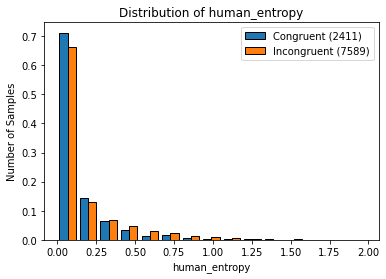

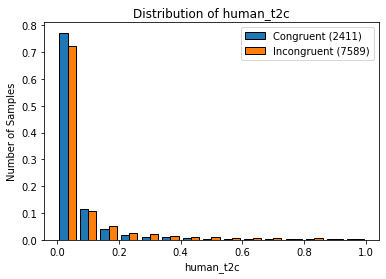

<Figure size 432x288 with 0 Axes>

In [62]:
# Separate plots for congruent vs incongruent
for confusion_metric in confusion_metrics:
    data = [congruent_df[confusion_metric].to_numpy(), incongruent_df[confusion_metric].to_numpy()]
    histogram(
        data=data,
        # weights=None,
        weights=[np.ones_like(cur_data) / len(cur_data) for cur_data in data],
        labels=["Congruent ({})".format(len(congruent_df)), "Incongruent ({})".format(len(incongruent_df))],
        n_bins=15,
        title="Distribution of {}".format(confusion_metric),
        xlabel=confusion_metric,
        ylabel="Number of Samples",
        show=True
    )


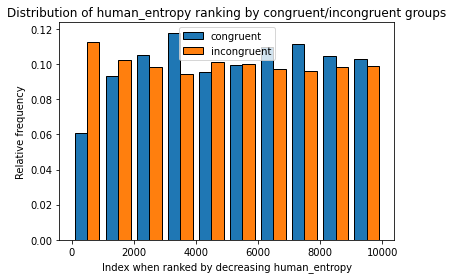

(array([[0.06055579, 0.09332227, 0.10493571, 0.11779345, 0.0953961 ,
         0.09954376, 0.10949813, 0.11157196, 0.10452095, 0.10286188],
        [0.1125313 , 0.10212149, 0.09843194, 0.09434708, 0.10146264,
         0.10014495, 0.09698247, 0.09632363, 0.09856371, 0.09909079]]),
 array([   0. ,  999.9, 1999.8, 2999.7, 3999.6, 4999.5, 5999.4, 6999.3,
        7999.2, 8999.1, 9999. ]),
 <a list of 2 BarContainer objects>)

<Figure size 432x288 with 0 Axes>

In [129]:
# Sort rows by highest entropy
sort_metric = 'human_entropy'
sorted_df = df.sort_values(sort_metric, ascending=False)
sorted_df['temp_idxs'] = [i for i in range(len(sorted_df))]
c_sorted_df = sorted_df[sorted_df['congruent'] == 1]
i_sorted_df = sorted_df[sorted_df['congruent'] == 0]


data = [c_sorted_df['temp_idxs'], i_sorted_df['temp_idxs']]

histogram(
    data=data,
    weights=[np.ones_like(cur_data) / len(cur_data) for cur_data in data],
    labels=['congruent', 'incongruent'],
    n_bins=10,
    xlabel='Index when ranked by decreasing {}'.format(sort_metric),
    ylabel='Relative frequency',
    title='Distribution of {} ranking by congruent/incongruent groups'.format(sort_metric),
    show=True)

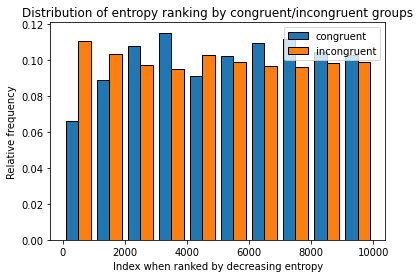

(array([[0.06594774, 0.08875985, 0.10783907, 0.11530485, 0.09124844,
         0.10244712, 0.10949813, 0.11157196, 0.10452095, 0.10286188],
        [0.11081829, 0.10357096, 0.09750955, 0.0951377 , 0.10278034,
         0.09922256, 0.09698247, 0.09632363, 0.09856371, 0.09909079]]),
 array([   0. ,  999.9, 1999.8, 2999.7, 3999.6, 4999.5, 5999.4, 6999.3,
        7999.2, 8999.1, 9999. ]),
 <a list of 2 BarContainer objects>)

<Figure size 432x288 with 0 Axes>

In [127]:
# sorted_df['temp_idxs'] = [i for i in range(len(sorted_df))]
# c_sorted_df = sorted_df[sorted_df['congruent'] == 1]
# i_sorted_df = sorted_df[sorted_df['congruent'] == 0]


# data = [c_sorted_df['temp_idxs'], i_sorted_df['temp_idxs']]

# histogram(
#     data=data,
#     weights=[np.ones_like(cur_data) / len(cur_data) for cur_data in data],
#     labels=['congruent', 'incongruent'],
#     n_bins=10,
#     xlabel='Index when ranked by decreasing entropy',
#     ylabel='Relative frequency',
#     title='Distribution of entropy ranking by congruent/incongruent groups',
#     show=True)